# Imports:

In [1]:
import numpy as np
import scipy.special as special

import matplotlib.pyplot as plt

# Constants:

In [2]:
## 1 atm in Pa
ps0 = 1.01325e5

## MEDIUM CONSTANTS
medium_density = 1204 # in g / m^3
speed_in_medium = 343 # m / s

# Methods:

## Calculates absorption coefficients for vector of frequencies given conditions

In [3]:
def absorption(f, t=20, rh=60, ps=ps0):
    """ In dB/m
    
        f: frequency in Hz
        t: temperature in °C
        rh: relative humidity in %
        ps: atmospheric pressure in Pa

        From http://en.wikibooks.org/wiki/Engineering_Acoustics/Outdoor_Sound_Propagation
        See __main__ for actual curves.
    """
    
    if type(f) != int:
        f = f.reshape(1, len(f))
    if type(t) != int:
        t = t.reshape(len(t), 1)
    if type(rh) != int:
        rh = rh.reshape(len(rh), 1)
    T = t + 273.15
    T0 = 293.15
    T01 = 273.16

    Csat = -6.8346 * np.power(T01 / T, 1.261) + 4.6151
    rhosat = np.power(10, Csat)
    H = rhosat * rh * ps0 / ps

    frn = (ps / ps0) * np.power(T0 / T, 0.5) * (
            9 + 280 * H * np.exp(-4.17 * (np.power(T0 / T, 1/3.) - 1)))

    fro = (ps / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

    alpha = f * f * (
        1.84e-11 / ( np.power(T0 / T, 0.5) * ps / ps0 )
        + np.power(T / T0, -2.5)
        * (
            0.10680 * np.exp(-3352 / T) * frn / (f * f + frn * frn)
            + 0.01278 * np.exp(-2239.1 / T) * fro / (f * f + fro * fro)
            )
        )

    return 20 * alpha / np.log(10)

## Initializes bat-related variables along with wavelength and *ka* values

In [4]:
### ASSUMING BAT GAPE HEIGHT OF 5-9MM IS PISTON DIAMETER
## a is piston radius
a = 0.003
bat_SL_in_dB = np.arange(110, 155, 5)
bat_frequency = 30000

### FIND THE WAVENUMBER GIVEN THE BAT FREQUENCY AND MOUTH APERTURE
wavelength = speed_in_medium / bat_frequency
k = 2*np.pi/wavelength
ka = k*a

## Initializes the r and theta values. We will assume r increases and theta stays at 0

In [5]:
### INITIALIZE THE RADIAL DISTANCE AND ANGLE THAT BAT IS TO MICROPHONE
r = np.arange(0, 100, 0.1)+1e-2
theta = np.zeros(len(r))+1e-12

### CHECK SHAPES
r.shape, theta.shape

((1000,), (1000,))

## Shows the absorption coefficient curves where I highlight the coefficient I will be using

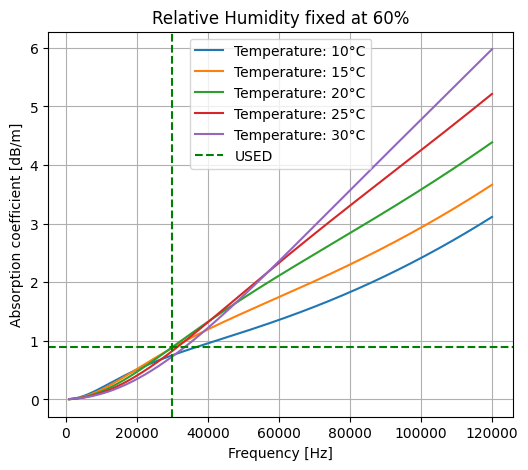

In [6]:
fs = np.linspace(int(1e3), int(1.2e5), int(1e3), endpoint=True)
t = np.arange(10, 35, 5)
t_labels = []
for temp in t:
    t_labels.append(f'Temperature: {temp}°C')
ys = absorption(fs, t=t)
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size':10})
fs = fs * np.ones((len(t), 1))
plt.title('Relative Humidity fixed at 60%')
plt.plot(fs.T, ys.T, label=t_labels)
plt.axhline(y=absorption(bat_frequency), linestyle='dashed', color='g')
plt.axvline(x=bat_frequency, linestyle='dashed', color='g', label='USED')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Absorption coefficient [dB/m]')
plt.legend()
plt.show()

## Below I plot the theta and r values of all possible microphones w.r.t. the bat

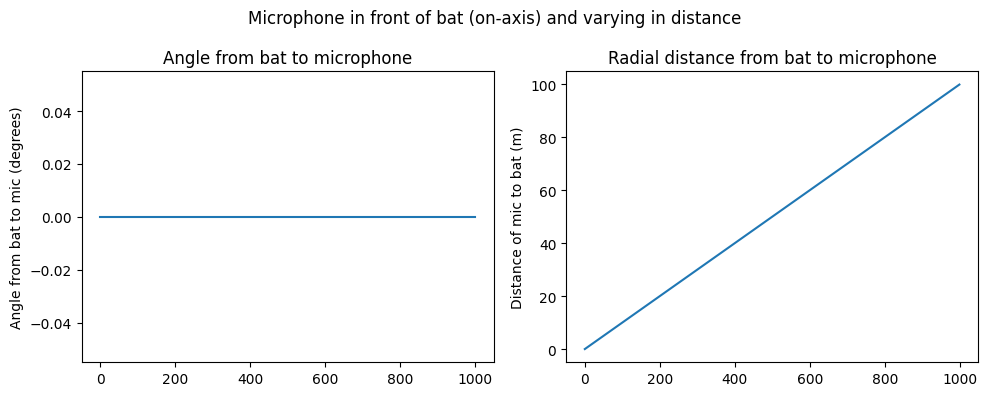

In [7]:
plt.figure(figsize=(10,4))

plt.suptitle('Microphone in front of bat (on-axis) and varying in distance')
plt.subplot(121)
plt.title('Angle from bat to microphone')
plt.plot(np.abs(theta*(180/np.pi)).round())
plt.ylabel('Angle from bat to mic (degrees)')

plt.subplot(122)
plt.title('Radial distance from bat to microphone')
plt.plot(r)
plt.ylabel('Distance of mic to bat (m)')

plt.tight_layout()
plt.show()

## Below I plot the directivity model I used for the bat's transmission beam pattern
This will tell us what any microphone placed around the bat will receive

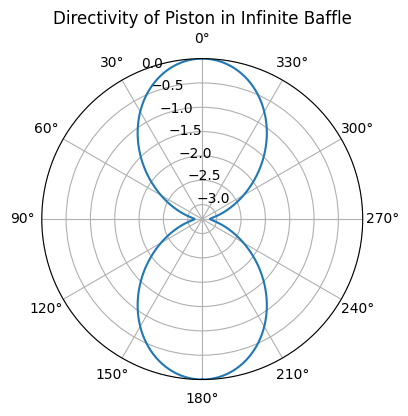

In [8]:
### Atmospheric attenuation found usinh Jakobsen at. al 2013
atmos_loss_DB = -1*absorption(bat_frequency)*r

### Directivity for piston in infinite baffle using Beranek et. al 2019
D_theta = 2*special.j1(ka*np.sin(theta))/(ka*np.sin(theta))
D_theta_dB = 20*np.log10(np.abs(D_theta))
clipped_D_theta_dB = np.clip(D_theta_dB, -24, None)

### Geometric Spreading calculated using Jakobsen et. al 2013
spreading_dB = -20*np.log10(r)

theta_polar = np.linspace(-np.pi, np.pi, 1000)
theta_polar = theta_polar.reshape(theta_polar.shape[0], 1)
D_theta_polar = 2*special.j1(ka*np.sin(theta_polar))/(ka*np.sin(theta_polar))
D_theta_polar_dB = 20*np.log10(np.abs(D_theta_polar))


fig = plt.figure(figsize=(8, 4))
a0 = fig.add_subplot(121, projection='polar')
a0.set_title(f"Directivity of Piston in Infinite Baffle")
a0.plot(theta_polar, D_theta_polar_dB)
a0.set_xticks(np.arange(0,2*np.pi,np.pi/6))
a0.set_theta_zero_location('N')

plt.tight_layout()
plt.show()

## Below I plot the 3 separate losses that will be included in TL (transmission loss)
- Loss to atmosphere: This is caused due to atmospheric absorption of energy
- Loss to directivity: This is caused due to the directionality in transmission from the bat's emitter
- Loss to spreading: This is caused due to the spherical spreading of sound.

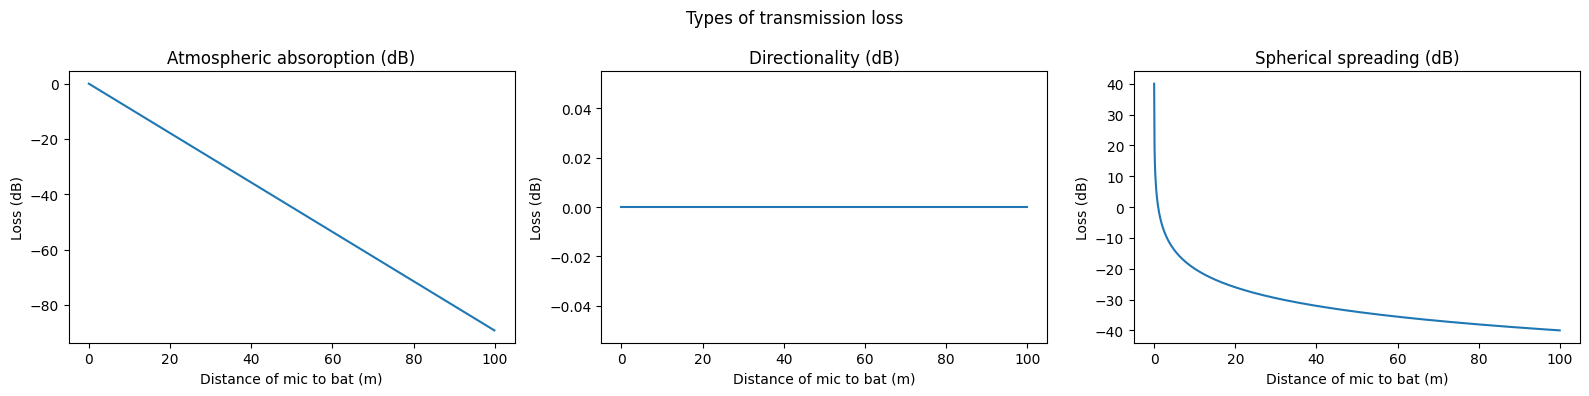

In [9]:
plt.figure(figsize=(16,4))

plt.suptitle('Types of transmission loss')
plt.subplot(131)
plt.title('Atmospheric absoroption (dB)')
plt.plot(r, atmos_loss_DB)
plt.ylabel('Loss (dB)')
plt.xlabel('Distance of mic to bat (m)')

plt.subplot(132)
plt.title('Directionality (dB)')
plt.plot(r, np.round(D_theta_dB))
plt.ylabel('Loss (dB)')
plt.xlabel('Distance of mic to bat (m)')

plt.subplot(133)
plt.title('Spherical spreading (dB)')
plt.plot(r, spreading_dB)
plt.ylabel('Loss (dB)')
plt.xlabel('Distance of mic to bat (m)')

plt.tight_layout()
plt.show()

## Below I calculate the transmission loss (TL) and add it to the bat SL to get SPL for the microphone

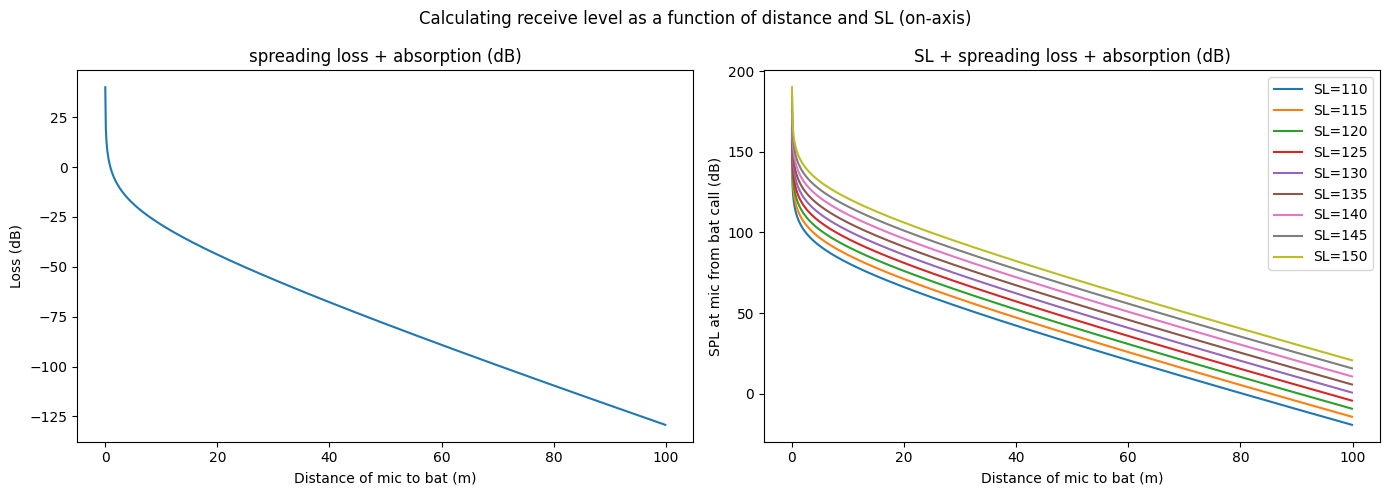

In [10]:
TL_dB = spreading_dB+D_theta_dB+atmos_loss_DB ### Frequency-dependent transmission loss!

RL_dB = TL_dB.reshape(1,len(TL_dB))+bat_SL_in_dB.reshape(len(bat_SL_in_dB),1) ### Receiver loss!

plt.figure(figsize=(14,5))

plt.suptitle('Calculating receive level as a function of distance and SL (on-axis)')
plt.subplot(121)
plt.title('spreading loss + absorption (dB)')
plt.plot(r, TL_dB)
plt.ylabel('Loss (dB)')
plt.xlabel('Distance of mic to bat (m)')

plt.subplot(122)
plt.title('SL + spreading loss + absorption (dB)')
plt.plot(r, RL_dB.T)
plt.ylabel('SPL at mic from bat call (dB)')
plt.xlabel('Distance of mic to bat (m)')
bat_labels = []
for batSL in bat_SL_in_dB:
    bat_labels += [f'SL={batSL}']
plt.legend(labels=bat_labels)

plt.tight_layout()
plt.show()

## Plugging in Audiomoth MEMS mic sensitivity and gain settings 
#### Sensitivity is -38dBV/Pa and gain is medium at -5.7dB with respect to high

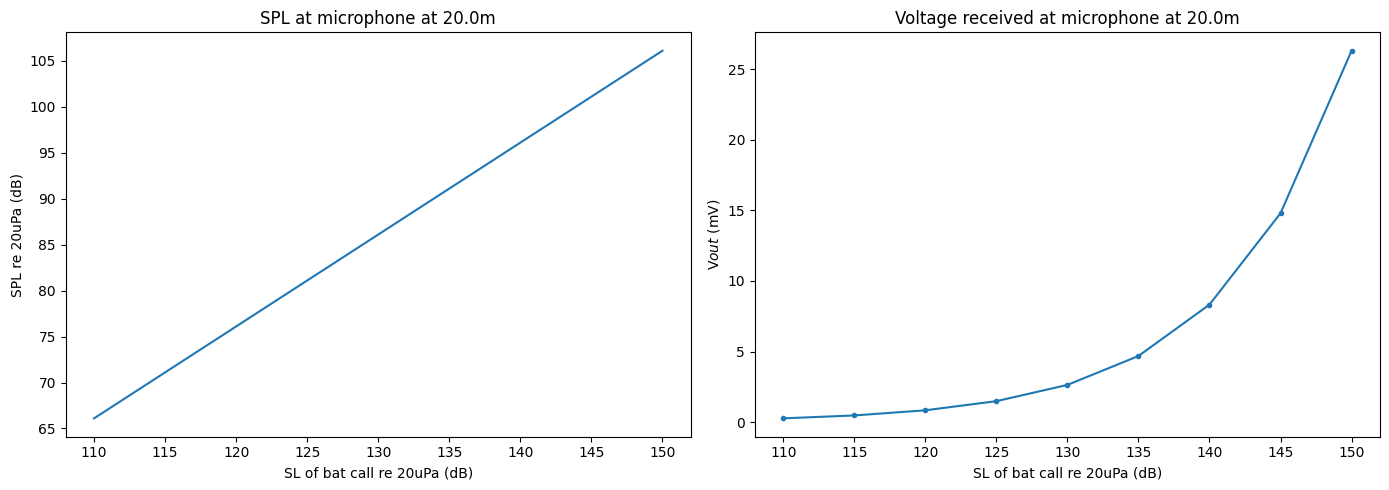

Voltages in mV: [ 0.26317024  0.46799023  0.83221738  1.47991504  2.63170244  4.67990226
  8.32217384 14.79915038 26.31702441]


In [25]:
mic_sensitivity_dBVperPa = -38
gain_setting_in_dB = -5.7
dBperPa = 94
dist = 20.0
RLper20uPa_at_dist = RL_dB[:,np.where(np.isclose(r,dist,atol=0.01))[0]]

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title(f'SPL at microphone at {dist}m')
plt.plot(bat_SL_in_dB, RLper20uPa_at_dist)
plt.ylabel(r'SPL re 20uPa (dB)')
plt.xlabel('SL of bat call re 20uPa (dB)')

voltage_out = np.power(10, (RLper20uPa_at_dist - 94 + mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

plt.subplot(122)
plt.title(f'Voltage received at microphone at {dist}m')
plt.plot(bat_SL_in_dB, voltage_out*1000, marker='.')
plt.ylabel(r'V$out$ (mV)')
plt.xlabel('SL of bat call re 20uPa (dB)')

plt.tight_layout()
plt.show()
print(f'Voltages in mV: {(1000*voltage_out).flatten()}')

## Plugging in Echometer Touch 2 Pro sensitivity and gain settings 
#### Sensitivity: -38 dBV/Pa, measured at 0 dB gain setting

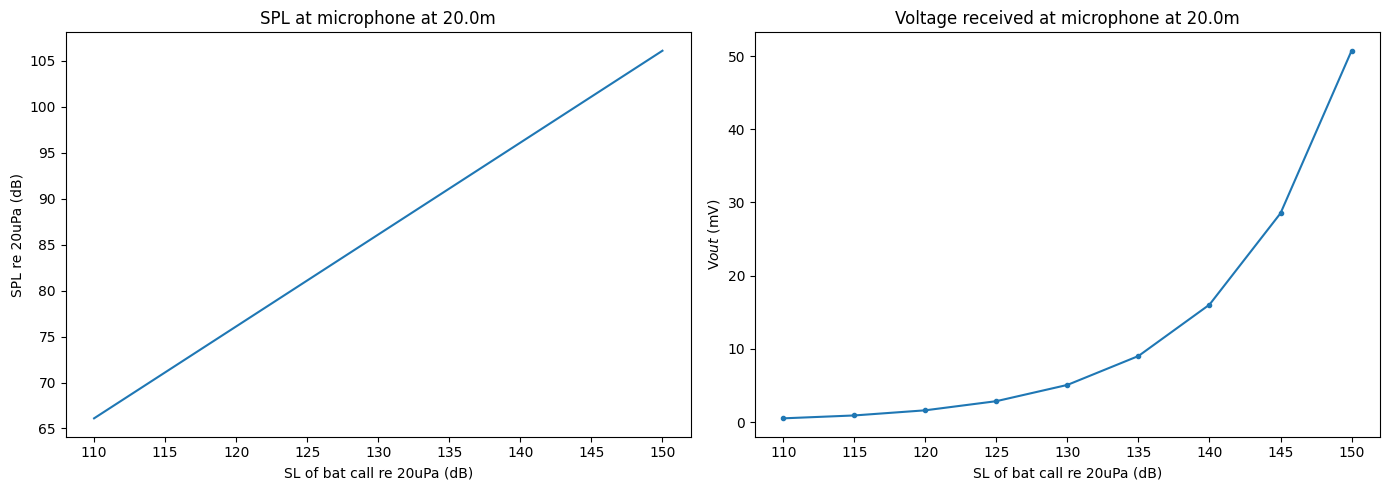

Voltages in mV: [ 0.5072672   0.90206282  1.60411974  2.85257311  5.07267202  9.02062821
 16.04119741 28.52573106 50.7267202 ]


In [26]:
mic_sensitivity_dBVperPa = -38
gain_setting_in_dB = 0
dBperPa = 94
dist = 20.0
RLper20uPa_at_dist = RL_dB[:,np.where(np.isclose(r,dist,atol=0.01))[0]]

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title(f'SPL at microphone at {dist}m')
plt.plot(bat_SL_in_dB, RLper20uPa_at_dist)
plt.ylabel(r'SPL re 20uPa (dB)')
plt.xlabel('SL of bat call re 20uPa (dB)')

voltage_out = np.power(10, (RLper20uPa_at_dist - 94 +  mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

plt.subplot(122)
plt.title(f'Voltage received at microphone at {dist}m')
plt.plot(bat_SL_in_dB, voltage_out*1000, marker='.')
plt.ylabel(r'V$out$ (mV)')
plt.xlabel('SL of bat call re 20uPa (dB)')

plt.tight_layout()
plt.show()
print(f'Voltages in mV: {(1000*voltage_out).flatten()}')

## Plugging in SONG METER SM4BAT FS sensitivity and gain settings 
#### Sensitivity: 20 dBfs re 1Pa, measured at 12 dB (default) gain setting

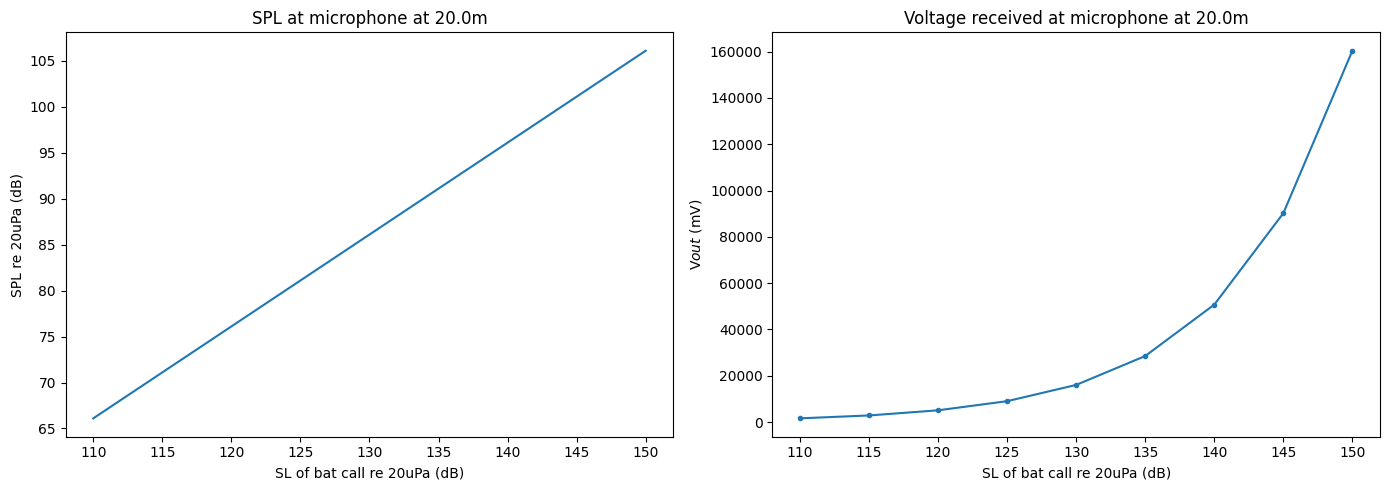

Voltages in mV: [  1604.11974056   2852.57310587   5072.6720198    9020.6282067
  16041.19740558  28525.73105872  50726.72019803  90206.28206696
 160411.97405584]


In [27]:
mic_sensitivity_dBVperPa = 20
gain_setting_in_dB = 12
dBperPa = 94
dist = 20.0
RLper20uPa_at_dist = RL_dB[:,np.where(np.isclose(r,dist,atol=0.01))[0]]

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title(f'SPL at microphone at {dist}m')
plt.plot(bat_SL_in_dB, RLper20uPa_at_dist)
plt.ylabel(r'SPL re 20uPa (dB)')
plt.xlabel('SL of bat call re 20uPa (dB)')

voltage_out = np.power(10, (RLper20uPa_at_dist - 94 +  mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

plt.subplot(122)
plt.title(f'Voltage received at microphone at {dist}m')
plt.plot(bat_SL_in_dB, voltage_out*1000, marker='.')
plt.ylabel(r'V$out$ (mV)')
plt.xlabel('SL of bat call re 20uPa (dB)')

plt.tight_layout()
plt.show()
print(f'Voltages in mV: {(1000*voltage_out).flatten()}')

## Plugging in Avisoft-Bioacoustics CM24/CMPA sensitivity and gain settings 
#### Approximate Sensitivity: 500mV/Pa, gain settings uncertain

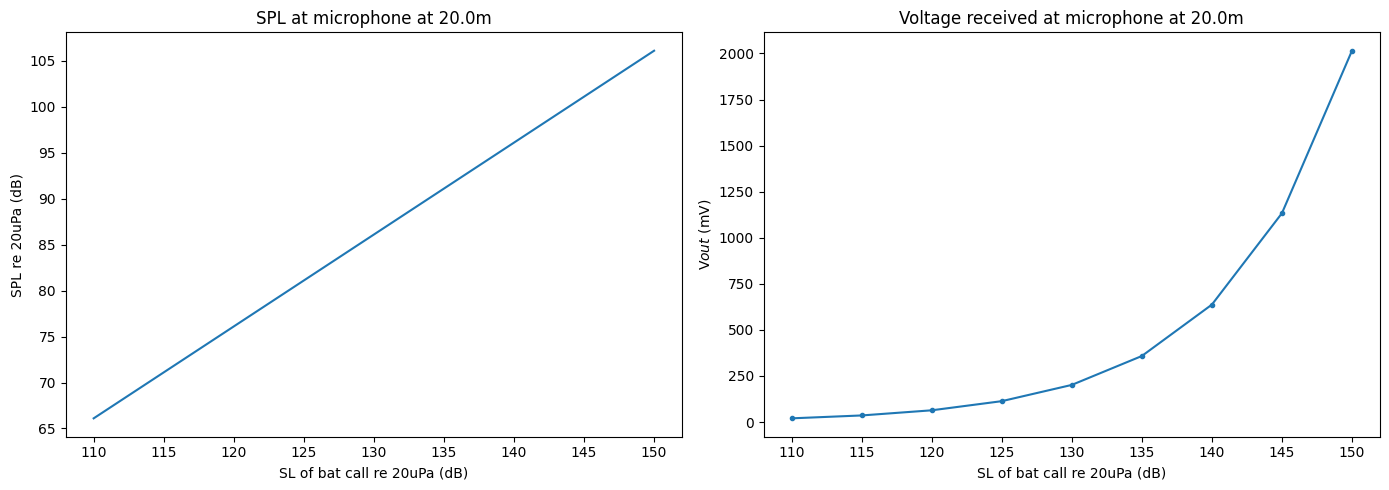

Voltages in mV: [  20.14683305   35.8266984    63.70988009  113.29396798  201.46833054
  358.26698398  637.0988009  1132.9396798  2014.68330541]


In [29]:
mic_sensitivity_dBVperPa = 20*np.log10(0.5)
gain_setting_in_dB = 0
dBperPa = 94
dist = 20.0
RLper20uPa_at_dist = RL_dB[:,np.where(np.isclose(r,dist,atol=0.01))[0]]

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title(f'SPL at microphone at {dist}m')
plt.plot(bat_SL_in_dB, RLper20uPa_at_dist)
plt.ylabel(r'SPL re 20uPa (dB)')
plt.xlabel('SL of bat call re 20uPa (dB)')

voltage_out = np.power(10, (RLper20uPa_at_dist - 94 + mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

plt.subplot(122)
plt.title(f'Voltage received at microphone at {dist}m')
plt.plot(bat_SL_in_dB, voltage_out*1000, marker='.')
plt.ylabel(r'V$out$ (mV)')
plt.xlabel('SL of bat call re 20uPa (dB)')

plt.tight_layout()
plt.show()
print(f'Voltages in mV: {(1000*voltage_out).flatten()}')

## Plugging in FG-23629-D65 Momimic mic sensitivity and gain settings 
#### Approximate Sensitivity: -55 dBV/0.1Pa, gain at 40dB

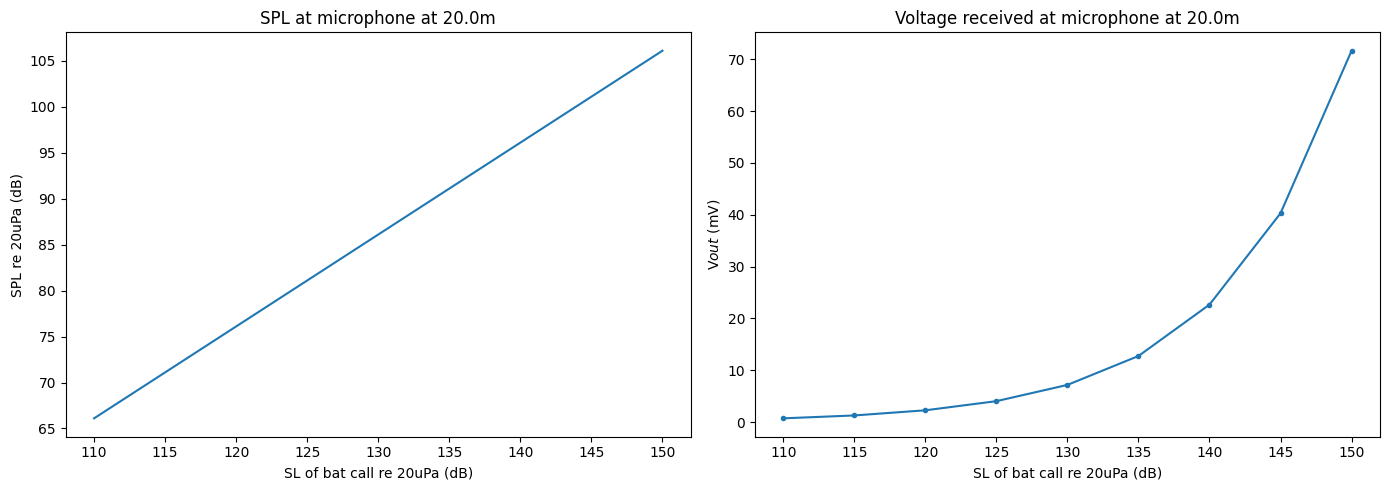

Voltages in mV: [ 0.71653397  1.2741976   2.26587936  4.02936661  7.16533968 12.74197602
 22.6587936  40.29366611 71.6533968 ]


In [30]:
mic_sensitivity_dBVperPa = -55 - 20
gain_setting_in_dB = 40
dBperPa = 94
dist = 20.0
RLper20uPa_at_dist = RL_dB[:,np.where(np.isclose(r,dist,atol=0.01))[0]]

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title(f'SPL at microphone at {dist}m')
plt.plot(bat_SL_in_dB, RLper20uPa_at_dist)
plt.ylabel(r'SPL re 20uPa (dB)')
plt.xlabel('SL of bat call re 20uPa (dB)')

voltage_out = np.power(10, (RLper20uPa_at_dist - 94 + mic_sensitivity_dBVperPa + gain_setting_in_dB)/20)

plt.subplot(122)
plt.title(f'Voltage received at microphone at {dist}m')
plt.plot(bat_SL_in_dB, voltage_out*1000, marker='.')
plt.ylabel(r'V$out$ (mV)')
plt.xlabel('SL of bat call re 20uPa (dB)')

plt.tight_layout()
plt.show()
print(f'Voltages in mV: {(1000*voltage_out).flatten()}')